# Caracterização da Base

A base de dados escolhida foi um conjunto de dados da Pro Football Reference referente ao draft de jogadores da NFL entre os anos de 1985 e 2015. Entre os dados temos informações relacionadas ao draft onde o jogador foi escolhido(ano, round de escolha, numero da escolha) e da carreira do jogador (anos de carreira, jogos totais, totais de destaques de temporada, postion-related data), parte da avaliação de cada jogador é quantificada pelo "Aproximate Value".

Apesar da base de dados ter um tamanho decente se fez necessária uma limpeza da base antes do incio das análises, principalmente devido a dados que estavam faltando para alguns jogadores, o primeiro passo então é definir valores default e remoção de linha irrelevantes.

## Data Cleaning

In [1]:
import sys
import pandas as pd
import numpy as np
import pandas_profiling
import matplotlib.pyplot as plt
%matplotlib inline

# Load da Base no Dataframe Pandas
sys.path.append('../')
df_draft = pd.read_csv('../data/raw_nfl_draft.csv')

# A partir da linha 5763 temos alguns valores trocados.
# Coloco os nomes das Universidades e as demais estatisticas nas colunas correspondentes
temp_int = df_draft['Tkl'][5763:8436] 
temp_sk = df_draft['Def_Int'][5763:8436]
temp_coll = df_draft['Sk'][5763:8436]

df_draft.loc[5793:8435, 'College/Univ'] = temp_coll
df_draft.loc[5793:8435, 'Sk'] = temp_sk
df_draft.loc[5793:8435, 'Def_Int'] = temp_int
df_draft.loc[5793:8435, 'Tkl'] = 0

# Seta valores 0 para valores faltando. Se esse valores estão ausentes, eles não foram realmente computados. 
# É normal eles estarem ausentes.
cols_to_zero = list(df_draft.columns[17:31])
df_draft[cols_to_zero] = df_draft[cols_to_zero].fillna(value=0)

# Jogadores que não tem o ano na coluna "To" são assumidos como não terem jogado, ou seja, são irrelevantes. 
# Podemos remover essas linhas
df_draft = df_draft[np.isfinite(df_draft['To'])]

# Valores nulos em Player_ID ( % )
df_draft['Player_Id'].isna().sum() / len(df_draft) * 100

# Cria coluna com os anos de carreira de cada jogador (Inclui ultimo ano)
df_draft['carrer_years'] = (df_draft['To'] - df_draft['Year']) + 1
df_draft.drop('Unnamed: 32',axis=1,inplace=True)
df_draft['Age'].fillna(22,inplace=True)

# Sava os dados tratados em outro arquivo csv
df_draft.to_csv('../data/clean_nfl_draft.csv')

df_draft.describe()

,Year,Rnd,Pick,First4AV,Age,To,AP1,PB,St,CarAV,...,Pass_Int,Rush_Att,Rush_Yds,Rush_TDs,Rec,Rec_Yds,Rec_Tds,Tkl,Def_Int,carrer_years
count,7053.000000,6845.000000,7053.000000,7053.000000,7053.000000,7053.000000,7053.000000,7053.000000,7053.000000,7053.000000,...,7053.000000,7053.000000,7053.000000,7053.000000,7053.000000,7053.000000,7053.000000,7053.000000,7053.000000,7053.000000
mean,1999.968099,4.437838,124.290940,11.872253,22.633631,2004.610804,0.088048,0.329931,2.189281,17.276195,...,1.593081,47.175386,193.171700,1.354034,32.535659,382.813980,2.280873,50.049482,1.519495,5.642705
std,9.099250,2.532512,78.395371,13.536436,0.842984,9.061308,0.508064,1.202619,3.127566,22.390409,...,12.982471,235.031017,988.638502,7.170983,106.574372,1367.736885,9.037410,122.064915,5.293794,3.580205
min,1985.000000,1.000000,1.000000,-4.000000,20.000000,1985.000000,0.000000,0.000000,0.000000,-4.000000,...,0.000000,0.000000,-36.000000,0.000000,0.000000,-19.000000,0.000000,0.000000,0.000000,1.000000
25%,1992.000000,2.000000,58.000000,1.000000,22.000000,1997.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
50%,2000.000000,4.000000,117.000000,6.000000,23.000000,2006.000000,0.000000,0.000000,1.000000,8.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,5.000000
75%,2008.000000,6.000000,186.000000,19.000000,23.000000,2013.000000,0.000000,0.000000,3.000000,26.000000,...,0.000000,0.000000,0.000000,0.000000,2.000000,18.000000,0.000000,25.000000,0.000000,8.000000
max,2015.000000,12.000000,336.000000,88.000000,29.000000,2016.000000,10.000000,14.000000,19.000000,177.000000,...,336.000000,4409.000000,18355.000000,164.000000,1549.000000,22895.000000,197.000000,1562.000000,95.500000,21.000000


## Profiling

Usamos um plugin do Pandas chamado Pandas Profiling que gera um pequeno relatório automaticamente e nos permite ganhar tempo partindo para análises mais interessantes.

Caso o notebook não execute por falta desse plugin basta intalar o mesmo usando o pip:

In [ ]:
# pip install pandas-profiling

In [2]:
#Cria profiling report

profile = pandas_profiling.ProfileReport(df_draft)
df_draft.profile_report()

O profiler nos retorna, logo no começo, um feedback sobre a saude geral da base. Temos um total de 34 variavéis com pouco mais de 7 mil observações, sendo que possuimos menos de 0.1% de celulas vazias no dataframe. No geral a limpeza dos dados foi bem sucedida.

O profiler nos permite ter uma visão mais interessante dos dados de maneira mais rápida, algumas observações que podem ser feitas são: 

- A média dos anos de carreira dos jogadores da base é de 5.6 anos apesar da base ter 30 anos de dados
- O estado que enviou mais jogadores para a NFL foi a Flórida
- A média de idade dos jogadores é de um pocuo mais de 22 anos

Além disso ele trás algumas informações mais especificas de cada variavel. Por exemplo:

- Existem 356 universidades na base
- Existem 24 possições distintas sendo Defensive Back, Line Backer e Wide Receiver as mais frequentes (18,7%; 13,2% e 12.2% respectivamente)

In [3]:
# Numero de Universidades unicas
print(len(df_draft['College/Univ'].unique()))
df_uni_agg = df_draft.groupby(['College/Univ']).size().sort_values(ascending=False).reset_index(name='count') 
df_uni_agg.head()

356


,College/Univ,count
0,Florida St.,148
1,Miami (FL),145
2,Florida,133
3,USC,133
4,Ohio St.,132


## Entendendo o valor da posição do jogador 

Agora que ja temos uma noção geral da base, vamos partir para uma anilise mais detalhada, como pretendemos fazer a regressão envolvendo as possições dos jogadores as anilises são feitas olhando para as posições.

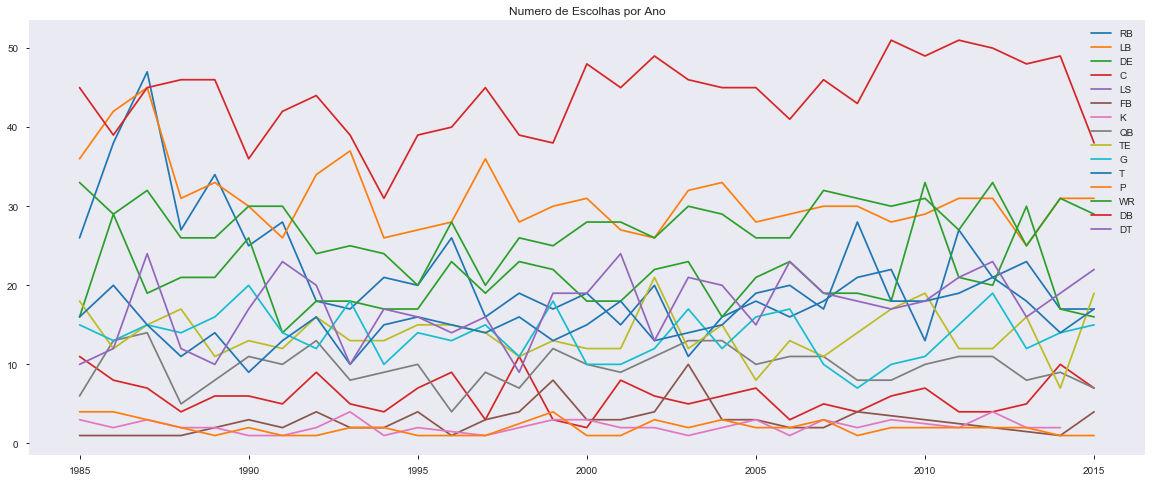

In [4]:
positions = list(set(df_draft['Position_Standard']))
df_positions = {}
info = list()
for pos in positions:
    df_positions[pos] = df_draft[df_draft['Position_Standard'] == pos]
    
plt.figure(figsize=(20,8))
title = "Numero de Escolhas por Ano"
plt.title(title)
plt.grid(axis="both")
for pos in positions:
    plt.plot(df_positions[pos].groupby('Year').count()['Pick'])
    plt.legend(positions)

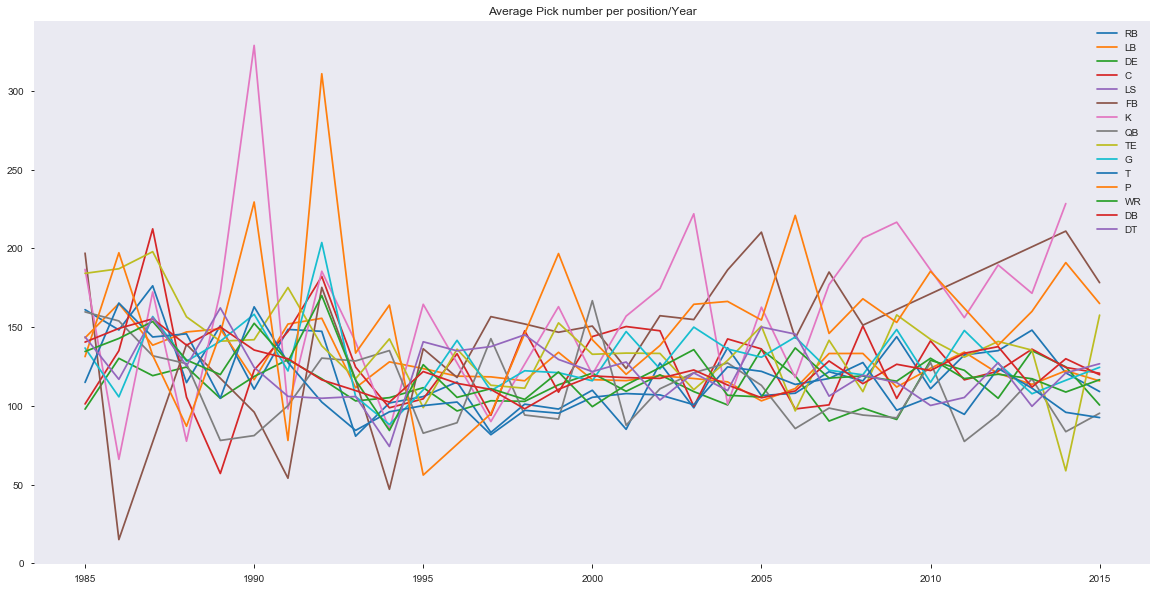

In [5]:
plt.figure(figsize=(20,10))
title = "Average Pick number per position/Year"
plt.title(title)
plt.grid(axis="both")
for pos in positions:
    plt.plot(df_positions[pos].groupby('Year').mean()['Pick'])
    plt.legend(positions)

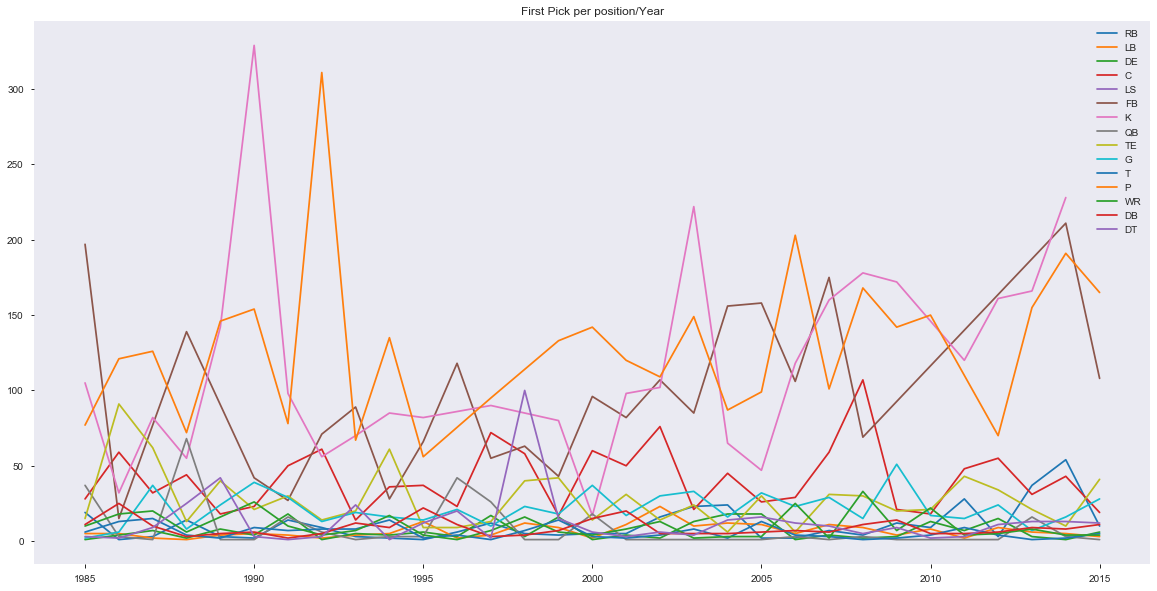

In [6]:
plt.figure(figsize=(20,10))
title = "First Pick per position/Year"
plt.title(title)
plt.grid(axis="both")
for pos in positions:
    plt.plot(df_positions[pos].groupby('Year').min()['Pick'])
    plt.legend(positions)

Apesar da posição Center ter um numero maior de escolhas por ano, fica claro que Line Back e Kiker são as posições vistas como impactantes. Sempre disputando as primeiras escolhas do draft o que indica uma valorisação maior dessas possições, principalmente no início dos anos 2000 quando as primeiras escolhas para as posições explodem.

Text(0.5, 1.0, 'Total Number of Quarterback picks/Year')

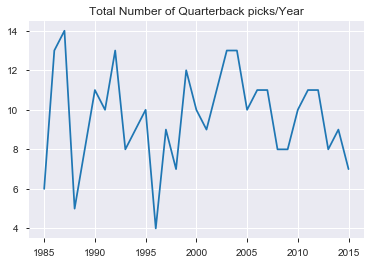

In [10]:
plt.plot(df_positions['QB'].groupby('Year').count()['Pick'])
plt.title("Total Number of Quarterback picks/Year")

Text(0.5, 1.0, 'Average Quarterback Pick number/Year')

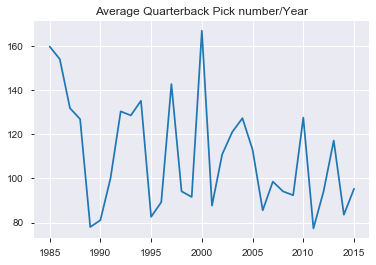

In [11]:
plt.plot(df_positions['QB'].groupby('Year').mean()['Pick'])
plt.title("Average Quarterback Pick number/Year")

Text(0.5, 1.0, 'Total Number of Running Backs picks/Year')

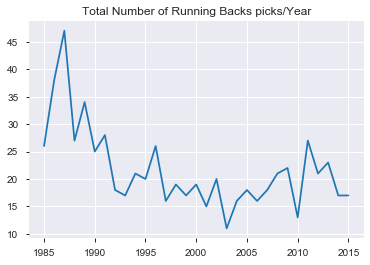

In [12]:
plt.plot(df_positions['RB'].groupby('Year').count()['Pick'])
plt.title("Total Number of Running Backs picks/Year")

Text(0.5, 1.0, 'Average Running Back Pick number/Year')

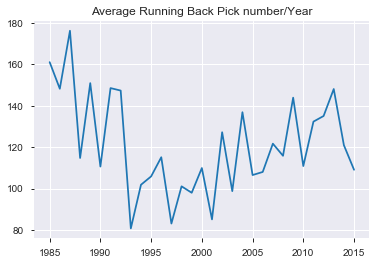

In [13]:
plt.plot(df_positions['RB'].groupby('Year').mean()['Pick'])
plt.title("Average Running Back Pick number/Year")

Text(0.5, 1.0, 'Total Number of Wide Receivers picks/Year')

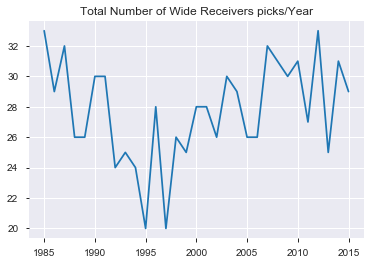

In [14]:
plt.plot(df_positions['WR'].groupby('Year').count()['Pick'])
plt.title("Total Number of Wide Receivers picks/Year")

Text(0.5, 1.0, 'Average Wide Receiver Pick number/Year')

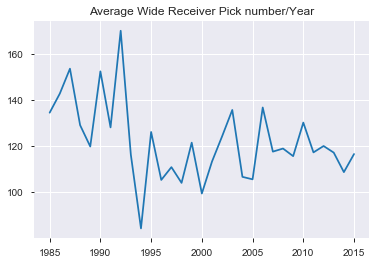

In [15]:
plt.plot(df_positions['WR'].groupby('Year').mean()['Pick'])
plt.title("Average Wide Receiver Pick number/Year")

In [17]:
#Total de posições que cada College/Univ "ofereceu" ao draft
College_Position = df_draft.groupby(['Position_Standard','College/Univ']).count()['Player_Id']

#Para cada posição, imprime o College/Univ. com mais atletas draftados da posição e a quantidade
for pos in positions:
    max_val = College_Position[pos].max() 
    top_pos = College_Position[pos].index[list(College_Position[pos]).index(max_val)]
    print("Position: " + pos + " -- " + "Top College: " + top_pos + ' -- ' + "Athlets: " + str(max_val))

Position: RB -- Top College: Miami (FL) -- Athlets: 16
Position: LB -- Top College: Penn St. -- Athlets: 25
Position: DE -- Top College: Florida St. -- Athlets: 14
Position: C -- Top College: Notre Dame -- Athlets: 8
Position: LS -- Top College: Navy -- Athlets: 1
Position: FB -- Top College: Auburn -- Athlets: 4
Position: K -- Top College: Georgia -- Athlets: 4
Position: QB -- Top College: Oregon -- Athlets: 9
Position: TE -- Top College: Notre Dame -- Athlets: 13
Position: G -- Top College: Penn St. -- Athlets: 13
Position: T -- Top College: Texas A&M -- Athlets: 12
Position: P -- Top College: Michigan St. -- Athlets: 4
Position: WR -- Top College: Florida St. -- Athlets: 22
Position: DB -- Top College: Nebraska -- Athlets: 32
Position: DT -- Top College: Florida St. -- Athlets: 17


In [19]:
#Draft AV por time a cada ano
DrAV_Team_Year = df_draft.groupby(['Tm','Year']).sum()['DrAV']

teams = set(df_draft['Tm'])
for team in teams:
    #print -- Time -- Best Year -- Year
    top_val = DrAV_Team_Year[team].max()
    top_year = DrAV_Team_Year[team].index[list(DrAV_Team_Year[team]).index(top_val)]
    print("Team: " + team + ' -- ' + "Best Draft: " + str(top_year) + ' -- ' + "DrAV: " + str(top_val))

Team: RAM -- Best Draft: 1994 -- DrAV: 170.0
Team: HOU -- Best Draft: 1995 -- DrAV: 182.0
Team: NOR -- Best Draft: 2006 -- DrAV: 286.0
Team: PHO -- Best Draft: 1991 -- DrAV: 135.0
Team: CIN -- Best Draft: 2001 -- DrAV: 210.0
Team: CHI -- Best Draft: 2003 -- DrAV: 235.0
Team: PIT -- Best Draft: 1987 -- DrAV: 292.0
Team: NWE -- Best Draft: 1993 -- DrAV: 244.0
Team: KAN -- Best Draft: 2008 -- DrAV: 189.0
Team: WAS -- Best Draft: 1986 -- DrAV: 133.0
Team: DEN -- Best Draft: 2006 -- DrAV: 148.0
Team: SFO -- Best Draft: 1986 -- DrAV: 345.0
Team: NYJ -- Best Draft: 2000 -- DrAV: 213.0
Team: GNB -- Best Draft: 2000 -- DrAV: 232.0
Team: TEN -- Best Draft: 2005 -- DrAV: 187.0
Team: MIN -- Best Draft: 1988 -- DrAV: 179.0
Team: PHI -- Best Draft: 1986 -- DrAV: 244.0
Team: DET -- Best Draft: 1989 -- DrAV: 197.0
Team: ATL -- Best Draft: 2008 -- DrAV: 248.0
Team: SDG -- Best Draft: 2004 -- DrAV: 212.0
Team: DAL -- Best Draft: 2005 -- DrAV: 241.0
Team: CAR -- Best Draft: 2001 -- DrAV: 187.0
Team: MIA 